# Monte Carlo Tree Search

Here I'll be trying to implement the Monte Carlo Tree Search algorithm on chess. The aim is to create this part of the self-play training pipeline in full.

Firstly, we need an instantiation of the model so we can build it into the algorithm.

In [1]:
import chess
import chess.pgn

import numpy as np
import tensorflow as tf
import keras

from functools import reduce

Using TensorFlow backend.


In [2]:
game = chess.pgn.Game()
board = game.board()

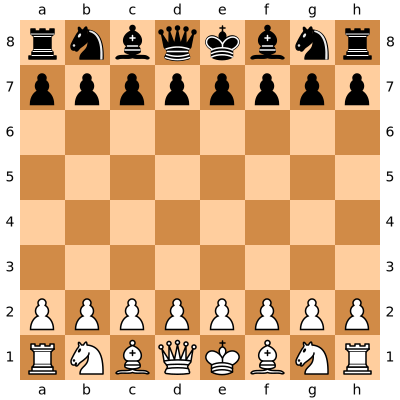

In [3]:
board

In [4]:
def featurise_board(board):
    board_data = np.zeros(shape = (12, 8, 8))
    
    def int_to_mask(squares):
        '''Takes a set of squares as an integer and returns an 8x8 matrix of the marked squares'''
        # convert int to binary
        squares = np.binary_repr(squares, width=64)
        # break int string into one-hot array
        squares = np.array([i for i in squares])
        # reshape into 8 by 8 matrix
        squares = squares.reshape(8,8)
        # flip along y axis (for some reason)
        squares = squares[:,::-1]
        # change type to int
        squares = squares.astype(np.int0)
        return squares

    for i, colour in enumerate(chess.COLORS):
        for j, piece in enumerate(chess.PIECE_TYPES):
            k = i * len(chess.PIECE_TYPES) + j
            piece_location = board.pieces_mask(color=colour, piece_type=piece)
            board_data[k, :, :] = int_to_mask(piece_location)
    return board_data

In [5]:
from keras import layers

FILTERS = 256

def residual_tower(X, num_blocks = 10, filters = FILTERS):
    '''
    Constructs a residual tower consisting of a convolutional block, followed
    by a sequence of `num_blocks` residual blocks, each of with a fixed number of
    filters.
    
    The residual tower output is passed to the policy + value heads for
    move prediction and board evaluation respectively'''
    
    def convolutional_block(X, filters = FILTERS, kernel_size = (3, 3), activation = True):
        '''
        The convolutional block for the network. Performs convolution with a given number
        of filters and kernel size.

        If an activation is given, then it will be applied to the output before the
        result is returned. If you want no activation function, then use activation = None'''

        # run y through convolutional layer
        y = layers.Conv2D(
                filters = filters, 
                kernel_size = kernel_size,
                data_format = 'channels_first',
                padding='same')(X)

        # Apply batch normalisation
        y = tf.layers.batch_normalization(y)
        if activation:
            # Apply activation function
            y = tf.nn.relu(y)

        # return output tensor
        return y
    
    def residual_block(X, activation = 'relu'):
        '''
        '''
        y = convolutional_block(X)
        y = convolutional_block(y, activation = None)
        X = convolutional_block(X, kernel_size = (1, 1), activation = None)
        y = tf.nn.relu(X + y)
        return y
    
    ## Construct Residual Tower:
    y = convolutional_block(X)
    for i in range(num_blocks):
        y = residual_block(y)
        
    def policy_head(y):
        '''
        '''
        y = convolutional_block(y, activation = True)
        y = layers.Flatten()(y)
        y = layers.Dense(units = 5000)(y)
        y = layers.Activation('softmax')(y)
        return y

    def value_head(y):
        '''
        '''
        y = convolutional_block(y)
        y = layers.Flatten()(y)
        y = layers.Dense(units = FILTERS, activation = 'relu')(y)
        y = layers.Dense(units = 1, activation = 'tanh')(y)
        return y
    
    return policy_head(y), value_head(y)

In [6]:
input_data = featurise_board(board)
input_data = input_data.reshape(1, 12, 8, 8)
input_data = input_data.astype(np.float32)

In [7]:
with tf.Session() as sess:
    X = tf.convert_to_tensor(input_data)
    policy, value = residual_tower(X)
    tf.global_variables_initializer().run()
    policy = policy.eval()
    value  = value.eval()
    sess.close()

AttributeError: 'Session' object has no attribute 'list_devices'

In [ ]:
def uci_to_array(uci):
    move_data = np.zeros((8, 8, 8, 8))
    letters = dict(zip('abcdefgh', range(8)))
    i, j, k, l = [letters[ch] if ch in letters else int(ch) for ch in uci]
    move_data[i, j - 1, k, l - 1] = 1
    return move_data

In [ ]:
legal_moves = reduce(lambda x, y: x + y, [uci_to_array(move.uci()) for move in board.legal_moves])
legal_moves = legal_moves > 0

In [ ]:
', '.join(sorted([m.uci() for m in board.legal_moves]))

In [ ]:
np.vstack(np.where(legal_moves > 0))

In [ ]:
# extract board moves and promotions from the policy head output
move_data = policy[0, :64 ** 2].reshape(8, 8, 8, 8)
prom_data = policy[0, -4:]

In [ ]:
# remove illegal board positions from policy output
if not any([len(m.uci()) == 5 for m in board.legal_moves]):
    # do not promote a pawn if it is not legal to do so
    prom_data[:] = 0

# do not make any illegal board moves
move_data[~legal_moves] = 0

# normalise move array
move_data = move_data/np.sum(move_data)

In [ ]:
', '.join(sorted([m.uci() for m in board.legal_moves]))

In [ ]:
move_selection = np.random.choice(np.arange(np.sum(move_data > 0)), p = move_data[move_data > 0])
np.vstack(np.where(move_data > 0))[:, move_selection]

In [ ]:
list(board.legal_moves)[move_selection]

In [ ]:
def array_to_uci(move_data, prom_data):
    i, j, k, l = move_data
    letters = dict(zip(range(8), 'abcdefgh'))
    prom_dict = dict(zip(range(4), 'qrbn'))
    if np.all(prom_data == 0):
        return letters[i] + str(j + 1) + letters[k] + str(l + 1)
    else:
        prom_piece = prom_dict[np.argmax(prom_data)]
        return letters[i + 1] + str(j) + letters[k] + str(l + 1) + prom_piece

In [ ]:
", ".join(sorted([m.uci() for m in board.legal_moves]))

Now we can generate random moves, we can build the model into the game simulation engine.

In [ ]:
def get_current_time():
    from datetime import datetime
    return datetime.strftime(datetime.now(), "%Y/%m/%d %H:%M:%S.%f")

def initialise_game():
    game = chess.pgn.Game()
    board = game.board()
    game.headers['Date'] = get_current_time()
    game.headers['Black'] = 'Random Agent'
    game.headers['White'] = 'Random Agent'
    return game, board

def simulate_game():
    
    def get_next_move(board):
        input_data = featurise_board(board)
        input_data = input_data.reshape(1, 12, 8, 8)
        input_data = input_data.astype(np.float32)
        
        with tf.Session() as sess:
            X = tf.convert_to_tensor(input_data)
            policy, value = residual_tower(X)
            tf.global_variables_initializer().run()
            policy = policy.eval()
            value  = value.eval()
            sess.close()
        
        legal_moves = reduce(lambda x, y: x + y, [uci_to_array(move.uci()) for move in board.legal_moves])
        legal_moves = legal_moves > 0
        
        # extract board moves and promotions from the policy head output
        move_data = policy[0, :8 ** 4].reshape(8, 8, 8, 8)
        prom_data = policy[0, -4:]
        
        # remove illegal board positions from policy output
        if not any([len(m.uci()) == 5 for m in board.legal_moves]):
            # do not promote a pawn if it is not legal to do so
            prom_data[:] = 0

        # do not make any illegal board moves
        move_data[~legal_moves] = 0

        # normalise move array
        move_data = move_data/np.sum(move_data)
        
        # select a move
        move_selection = np.random.choice(np.arange(np.sum(move_data > 0)), p = move_data[move_data > 0])
        move_uci = array_to_uci(np.vstack(np.where(move_data > 0))[:, move_selection], prom_data)
        print(move_uci)
        return chess.Move.from_uci(move_uci)
        
    game, board = initialise_game()
    next_move = get_next_move(board)
    node = game.add_variation(next_move)
    board.push(next_move)
    while not board.is_game_over():
        next_move = get_next_move(board)
        node = node.add_variation(next_move)
        board.push(next_move)
    
    game.headers['Result'] = board.result()
    
    return game, board

In [ ]:
game, board = simulate_game()
print(game)
board